<a href="https://colab.research.google.com/github/HilkarSoberanes/MachineLearning/blob/main/MNIST_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=4 color='cornflowerblue'>

# Autoencoder Implementation using the dataset MNIST



The MNIST dataset is comprised of 70000 28 pixels by 28 pixels images of handwritten digits and 70000 vectors containing information on which digit each one is.

## Importing Necessary Modules/Packages 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

### Loading MNIST Data

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

The image training data is normalized i.e. scaled from [0, 255] to [0,1], this allows the use of the sigmoid activation function.

### Image denoising

An autoencoder can be trained to remove noise from images. We will create a noisy version of the MNIST dataset by applying random noise to each image. And then we will train an autoencoder using the noisy image as input, and the original image as the target.

Adding random noise to the images

In [3]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images

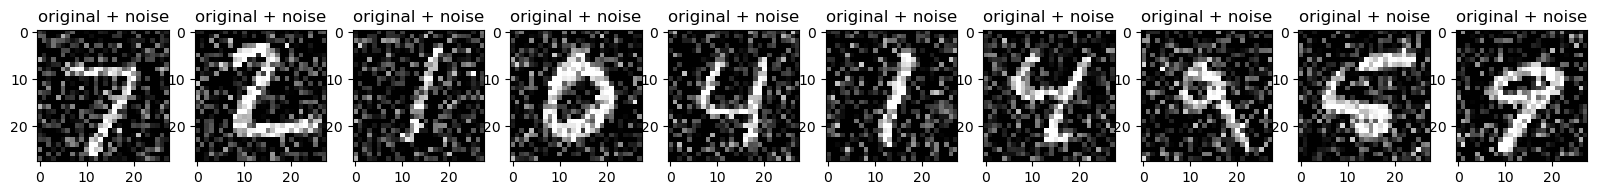

In [4]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

## Convolutional Autoencoder

We define an encoder with convolutional layers and a decoder with convolutiional transposed layers. The latent dimension is set to 16.

### Build the Encoder

In [5]:
latent_dim = 16

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(8, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z = layers.Dense(latent_dim, name="z")(x)
encoder = Model(encoder_inputs, z, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 16)          1168      
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 16)                25104     
                                                                 
 z (Dense)                   (None, 16)                272 

### Build the decoder

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 16, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 16))(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(8, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 784)               13328     
                                                                 
 reshape (Reshape)           (None, 7, 7, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 32)         4640      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 16)       4624      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 8)        1160

In [7]:
class Autoencoder(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(encoder, decoder)

In [8]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=losses.MeanSquaredError())

In [9]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=30,
                shuffle=True,
                validation_data=(x_test_noisy, x_test), batch_size=32)

Epoch 1/30
1875/1875 [==============================] - 26s 10ms/step - loss: 0.0753 - val_loss: 0.0462
Epoch 2/30
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0386 - val_loss: 0.0348
Epoch 3/30
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0332 - val_loss: 0.0313
Epoch 4/30
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0309 - val_loss: 0.0295
Epoch 5/30
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0292 - val_loss: 0.0281
Epoch 6/30
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0278 - val_loss: 0.0268
Epoch 7/30
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0267 - val_loss: 0.0258
Epoch 8/30
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0257 - val_loss: 0.0247
Epoch 9/30
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0245 - val_loss: 0.0235
Epoch 10/30
1875/1875 [==============================] - 18s 10ms/

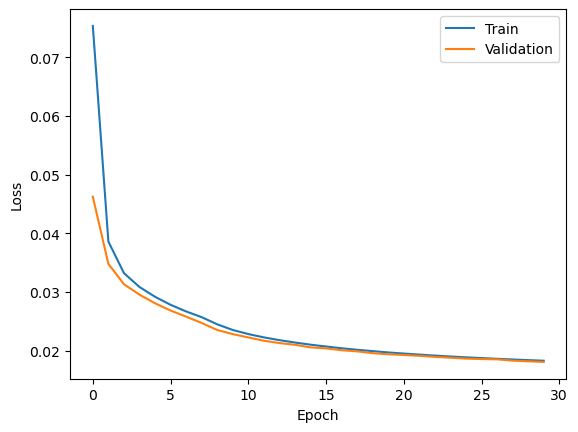

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [11]:
x_test_noisy = tf.random.shuffle(x_test_noisy)

In [12]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

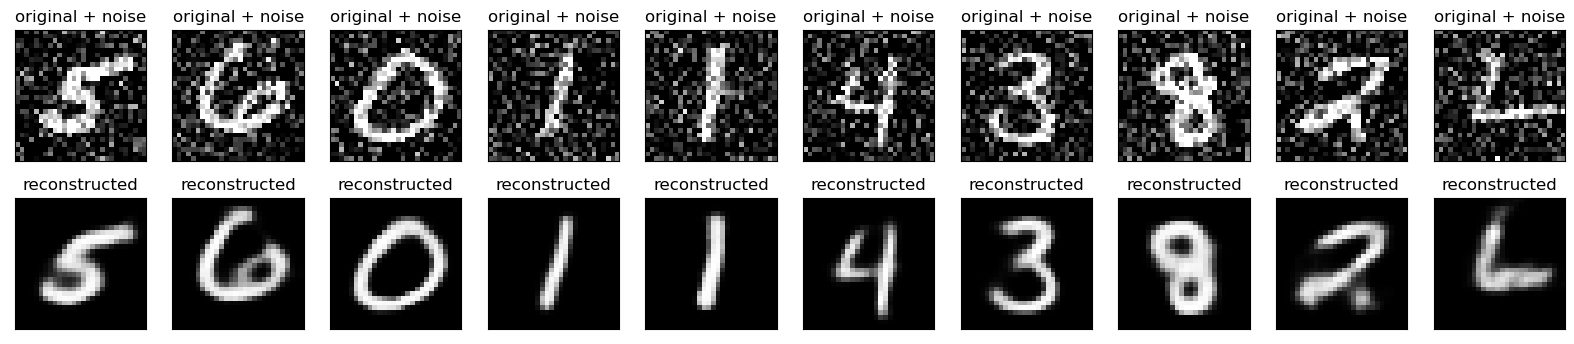

In [13]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [18]:
evaluations = autoencoder.evaluate(x = x_test_noisy, y = x_test) #Use test sets not included in training 

print ("Loss = " + str(evaluations))

313/313 [==============================] - 3s 9ms/step - loss: 0.1163
Loss = 0.11625325679779053
